# 2: The Image Classification Dataset

In [2]:
%matplotlib inline
import time
import torch
import torchvision
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

## Dataset

In [4]:
class FashionMNIST(d2l.DataModule):     #@save
    """The Fashion-MNIST dataset."""
    def __init__(self, batch_size = 64, resize = (28, 28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize),
                                    transforms.ToTensor()])
        self.train = torchvision.datasets.FashionMNIST(
            root = self.root, train=True, transform=trans, download=True
        )
        self.val = torchvision.datasets.FashionMNIST(
            root = self.root, train=False, transform=trans, download=True
        )

There are 10 categories, each with 6000 training images and 1000 test images.

In [5]:
data = FashionMNIST(resize=(32, 32))
len(data.train), len(data.val)

0.7%

100.0%


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100.0%


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100.0%


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100.0%

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



(60000, 10000)

The convention for storing images is *c x h x w*, with *c* being the number of channels.

In [6]:
data.train[0][0].shape

torch.Size([1, 32, 32])

In [7]:
@d2l.add_to_class(FashionMNIST)     #@save
def text_labels(self, indices):
    """Return text labels"""
    labels = ['t-shirt', 'trousers', 'pullover', 'dress', 'coat',
              'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [labels[int(i)] for i in indices]

## Reading a minibatch

Let's use the built-in data iterator:

In [8]:
@d2l.add_to_class(FashionMNIST)     #@save
def get_dataloader(self, train):
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train, num_workers=self.num_workers)

In [9]:
X, y = next(iter(data.train_dataloader()))
print(X.shape, X.dtype, y.shape, y.dtype)

torch.Size([64, 1, 32, 32]) torch.float32 torch.Size([64]) torch.int64


We can take a look at how fast the dataloader is

In [10]:
tic = time.time()
for X, y in data.train_dataloader():
    continue
f'{time.time()-tic:.2f} sec'

'1.46 sec'

## Visualizing the dataset

In [11]:
def show_images(imgs, num_rows, num_cols, titles = None, scale=1.5):       #@save
    """Plot a list of images."""
    raise NotImplementedError

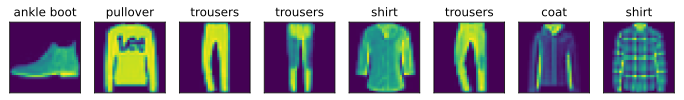

In [12]:
@d2l.add_to_class(FashionMNIST)     #@save
def visualize(self, batch, nrows = 1, ncols = 8, labels=[]):
    X, y = batch
    if not labels:
        labels = self.text_labels(y)
    d2l.show_images(X.squeeze(1), nrows, ncols, titles=labels)
    
batch=next(iter(data.val_dataloader()))
data.visualize(batch)

# 3: The base classification model

In [13]:
import torch
from d2l import torch as d2l

## Classifier

In [14]:
class Classifier(d2l.Module):       #@save
    """The base class of classification models."""
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)

In [15]:
@d2l.add_to_class(d2l.Module)       #@save
def configure_optimizer(self):
    return torch.optim.SGD(self.parameters(), lr = self.lr)

## Accuracy

The classification accuracy is the fraction of all predictions that are correct, where a prediction is choosing the class with the highest probability.

In [16]:
@d2l.add_to_class(Classifier)       #@save
def accuracy(self, Y_hat, Y, averaged=True):
    """Compute the number of correct predictions."""
    Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
    print(Y_hat.shape[-1])
    print(Y_hat.shape)
    preds = Y_hat.argmax(axis=1).type(Y.dtype)
    compare = (preds == Y.reshape(-1)).type(torch.float32)
    return compare.mean() if averaged else compare

# 4: Softmax Regression Implementation from Scratch

In [17]:
import torch
from d2l import torch as d2l

# The softmax

In [18]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdims=True), X.sum(1, keepdims=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [19]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    return X_exp / partition

In [20]:
X = torch.rand((2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.2020, 0.2185, 0.2310, 0.1976, 0.1509],
         [0.1177, 0.2365, 0.1391, 0.2152, 0.2915]]),
 tensor([1.0000, 1.0000]))

## Model

Note that the number of outputs of our network should be equal to the number of classes.

In [21]:
class SoftmaxRegressionScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W = torch.normal(0, sigma, size = (num_inputs, num_outputs), 
                              requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)

    def parameters(self):
        return [self.W, self.b]

In [22]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def forward(self, X):
    X = X.reshape((-1, self.W.shape[0]))
    return softmax(torch.matmul(X, self.W) + self.b)

# The Cross-Entropy Loss

We can use y as the *indices of the probabilities in y_hat*, picking out terms efficiently.

In [23]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [28]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[list(range(len(y_hat))), y]).mean()

cross_entropy(y_hat, y)

tensor(1.4979)

In [26]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def loss(self, y_hat, y):
    return cross_entropy(y_hat, y)

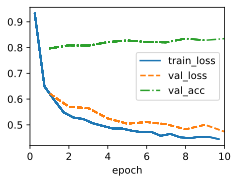

In [29]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr = 0.1)
trainer= d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

In [30]:
X, y = next(iter(data.val_dataloader()))
preds = model(X).argmax(axis=1)
preds.shape

torch.Size([256])

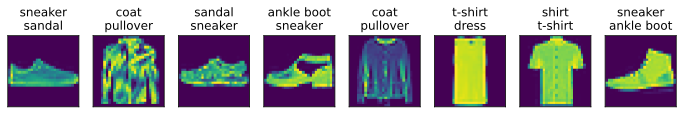

In [31]:
wrong = preds.type(y.dtype) != y
X, y, preds = X[wrong], y[wrong], preds[wrong]
labels = [a+ '\n' + b for a, b in zip(
    data.text_labels(y), data.text_labels(preds))]
data.visualize([X, y], labels=labels)

# 5: Coincise implementation of Softmax Regression

In [32]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

## Model

In [33]:
class SoftmaxRegression(d2l.Classifier):    #@save
    """The Softmax regression model."""
    def __init__(self, num_outputs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(),
                                 nn.LazyLinear(num_outputs))
        
    def forward(self, X):
        return self.net(X)

## Softmax (loss function)

In [40]:
@d2l.add_to_class(d2l.Classifier)   #@save
def loss(self, Y_hat, Y, averaged=True):
    Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
    Y = Y.reshape((-1,))
    return F.cross_entropy(Y_hat, Y, reduction='mean' if averaged else 'none')

## Training

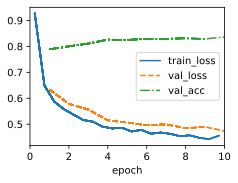

In [39]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegression(num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)